In [2]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
tqdm.pandas()

In [3]:
#Just featurize each config with its 1) config-level features and 2) average all node features and assign to the config
#Output is simple dataframe with one config per row, its runtime, and features
class TileDataExtractor:
    def __init__(self, directory, split):
        self.directory = os.path.join(directory, split)
        self.data = []

    def load_data(self):
        for filename in tqdm(os.listdir(self.directory)):
            filepath = os.path.join(self.directory, filename)
            self.process_file(filepath, filename)

    def process_file(self, filepath, filename):
        data = np.load(filepath)
        config_feat = data['config_feat']
        node_feat = data['node_feat']
        node_feat_avg = np.mean(node_feat, axis=0)
        runtime = data['config_runtime']
        runtime_norm = data['config_runtime_normalizers']
        
        for i in range(len(config_feat)):
            row = {
                'config_id': f"{filename}",
                'config_feat': config_feat[i],
                'node_feat_avg': node_feat_avg,
                'runtime': runtime[i],
                'runtime_norm': runtime_norm[i]
            }
            self.data.append(row)

    def get_dataframe(self):
        return pd.DataFrame(self.data)

In [3]:
#extractor = TileDataExtractor('/kaggle/input/predict-ai-model-runtime/npz_all/npz/tile/xla', 'train')
#extractor.load_data()
#df_train = extractor.get_dataframe()

In [4]:
# Unpack 'config_feat'
#config_feat_df = df_train['config_feat'].apply(pd.Series)
#config_feat_df.columns = [f'config_feat_{i}' for i in range(config_feat_df.shape[1])]

# Unpack 'node_feat_avg'
#node_feat_avg_df = df_train['node_feat_avg'].apply(pd.Series)
#node_feat_avg_df.columns = [f'node_feat_avg_{i}' for i in range(node_feat_avg_df.shape[1])]

# Concatenate with the original DataFrame
#df_train = pd.concat([df_train.drop(['config_feat', 'node_feat_avg'], axis=1), config_feat_df, node_feat_avg_df], axis=1)

We only use the "validation" dataset for this project, due to environment and resource constraints.

In [5]:
extractor = TileDataExtractor('/kaggle/input/predict-ai-model-runtime/npz_all/npz/tile/xla', 'valid')
extractor.load_data()
df_valid = extractor.get_dataframe()

100%|██████████| 676/676 [00:06<00:00, 101.46it/s]


In [6]:
del extractor

Unpack features into columns of dataframe

In [1]:
df_valid.head()

NameError: name 'df_valid' is not defined

In [8]:
# Unpack 'config_feat'
config_feat_df = df_valid['config_feat'].apply(pd.Series)
config_feat_df.columns = [f'config_feat_{i}' for i in range(config_feat_df.shape[1])]

# Unpack 'node_feat_avg'
node_feat_avg_df = df_valid['node_feat_avg'].apply(pd.Series)
node_feat_avg_df.columns = [f'node_feat_avg_{i}' for i in range(node_feat_avg_df.shape[1])]

# Concatenate with the original DataFrame
df_valid = pd.concat([df_valid.drop(['config_feat', 'node_feat_avg'], axis=1), config_feat_df, node_feat_avg_df], axis=1)

In [ ]:
#extractor = TileDataExtractor('/kaggle/input/predict-ai-model-runtime/npz_all/npz/tile/xla', 'test')
#extractor.load_data()
#df_test = extractor.get_dataframe()

In [ ]:
# Unpack 'config_feat'
#config_feat_df = df_test['config_feat'].apply(pd.Series)
#config_feat_df.columns = [f'config_feat_{i}' for i in range(config_feat_df.shape[1])]

# Unpack 'node_feat_avg'
#node_feat_avg_df = df_test['node_feat_avg'].apply(pd.Series)
#node_feat_avg_df.columns = [f'node_feat_avg_{i}' for i in range(node_feat_avg_df.shape[1])]

# Concatenate with the original DataFrame
#df_test = pd.concat([df_test.drop(['config_feat', 'node_feat_avg'], axis=1), config_feat_df, node_feat_avg_df], axis=1)

In [9]:
del config_feat_df
del node_feat_avg_df

In [10]:
#df_train['target'] = df_train['runtime'] / df_train['runtime_norm']
#df_train = df_train.drop(columns=['runtime', 'runtime_norm'])

Normalize the runtime/target column

In [11]:
df_valid['target'] = df_valid['runtime'] / df_valid['runtime_norm']

In [ ]:
#df_test['target'] = df_test['runtime'] / df_test['runtime_norm']
#df_test = df_test.drop(columns=['runtime', 'runtime_norm'])

Minmax scale the target, grouped by config ID. We only care about the relative ordering.

In [13]:
%%capture --no-stderr

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Iterate over each config_id and scale the target column within each group
for config_id in df_valid['config_id'].unique():
    # Selecting the rows corresponding to the current config_id
    idx = df_valid['config_id'] == config_id
    
    # Scaling the target column for the current group
    df_valid.loc[idx, 'target'] = scaler.fit_transform(df_valid.loc[idx, ['target']])

In [41]:
#Save preprocessed data
df_valid.to_csv("processed_data.csv", index=False)

Start from here with preprocessed data loaded.

In [15]:
df_valid = pd.read_csv("processed_data.csv")

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

Train test split, ensuring that configurations of the same model are not in different splits

In [25]:
unique_config_ids = df_valid['config_id'].unique()
train_config_ids, test_config_ids = train_test_split(unique_config_ids, test_size=0.2, random_state=42)

# Creating train and test dataframes based on config_id
train_df = df_valid[df_valid['config_id'].isin(train_config_ids)]
test_df = df_valid[df_valid['config_id'].isin(test_config_ids)]

# Separating features and target variable
X_train = train_df.drop(['target', 'config_id', 'runtime', 'runtime_norm'], axis=1)
y_train = train_df['target']
X_test = test_df.drop(['target', 'config_id', 'runtime', 'runtime_norm'], axis=1)
y_test = test_df['target']

In [18]:
!pip install LightGBM
from lightgbm import LGBMRegressor

In [26]:
#obtained from gridsearchcv
lasso_alpha = 0.01
ridge_alpha = 0.001

lr = LinearRegression()
lasso = Lasso(alpha = lasso_alpha)
ridge = Ridge(alpha = ridge_alpha)
lgbm = LGBMRegressor(colsample_bytree= 0.9029527732718773,
 learning_rate= 0.05,
 min_child_samples= 465,
 min_child_weight= 0.02476027076966974,
 n_estimators= 1500,
 num_leaves= 26,
 reg_alpha= 10,
 reg_lambda= 0.1,
 subsample= 0.9672960197116944)

models = [lr, lasso, ridge, lgbm]
for model in tqdm(models):
    model.fit(X_train, y_train)

100%|██████████| 4/4 [03:38<00:00, 54.60s/it]


In [27]:
# Making predictions
train_preds_lr = lr.predict(X_train)
train_preds_lasso = lasso.predict(X_train)
train_preds_ridge = ridge.predict(X_train)
train_preds_lgbm = lgbm.predict(X_train)

test_preds_lr = lr.predict(X_test)
test_preds_lasso = lasso.predict(X_test)
test_preds_ridge = ridge.predict(X_test)
test_preds_lgbm = lgbm.predict(X_test)

# Calculating R² scores
test_r2_lr = r2_score(y_test, test_preds_lr)
test_r2_lasso = r2_score(y_test, test_preds_lasso)
test_r2_ridge = r2_score(y_test, test_preds_ridge)
test_r2_lgbm = r2_score(y_test, test_preds_lgbm)

train_r2_lr= r2_score(y_train, train_preds_lr)
train_r2_lasso = r2_score(y_train, train_preds_lasso)
train_r2_ridge = r2_score(y_train, train_preds_ridge)
train_r2_lgbm = r2_score(y_train, train_preds_lgbm)

print("R² Scores Train:")
print(f"Linear Regression: {train_r2_lr}")
print(f"Lasso Regression: {train_r2_lasso}")
print(f"Ridge Regression: {train_r2_ridge}")
print(f"LGBM Regression: {train_r2_lgbm}")

print("R² Scores Test:")
print(f"Linear Regression: {test_r2_lr}")
print(f"Lasso Regression: {test_r2_lasso}")
print(f"Ridge Regression: {test_r2_ridge}")
print(f"LGBM Regression: {test_r2_lgbm}")

R² Scores Train:
Linear Regression: 0.14804314089279347
Lasso Regression: 0.09780982929324267
Ridge Regression: 0.14692412670734478
LGBM Regression: 0.933511331680336
R² Scores Test:
Linear Regression: -1.1858048727759058
Lasso Regression: 0.10090209410361695
Ridge Regression: -0.8934370236297771
LGBM Regression: 0.7127558555072704


The following code calculates the top K=5 slowdown for predictions.

In [28]:
def rank_configurations(predictions, full_df):
    ranked_configurations = []

    # Create a mapping of DataFrame indices to the range of indices in predictions
    index_mapping = {idx: i for i, idx in enumerate(full_df.index)}

    # Group data by 'config_id' and process each group
    for config_id, group in full_df.groupby('config_id'):
        # Get the corresponding prediction indices for the current group
        prediction_indices = [index_mapping[idx] for idx in group.index]

        # Rank configurations by predicted runtime
        ranked_indices = group.index[np.argsort(predictions[prediction_indices])]

        # Store the original indices of the ranked configurations
        ranked_configurations.append(list(ranked_indices))

    return ranked_configurations


In [29]:
ranked_train_lr = rank_configurations(train_preds_lr, train_df)
ranked_test_lr = rank_configurations(test_preds_lr, test_df)

ranked_train_lasso = rank_configurations(train_preds_lasso, train_df)
ranked_test_lasso = rank_configurations(test_preds_lasso, test_df)

ranked_train_ridge = rank_configurations(train_preds_ridge, train_df)
ranked_test_ridge = rank_configurations(test_preds_ridge, test_df)

ranked_train_lgbm = rank_configurations(train_preds_lgbm, train_df)
ranked_test_lgbm = rank_configurations(test_preds_lgbm, test_df)

true_ranked_train = rank_configurations(y_train.to_numpy(), train_df)
true_ranked_test = rank_configurations(y_test.to_numpy(), test_df)

In [30]:
def calculate_top_k_slowdown(predicted_rankings, full_df, runtime_column='runtime', k=5):
    total_slowdown = 0
    num_models = len(predicted_rankings)

    for predicted in tqdm(predicted_rankings):
        # Extract the top-k predicted configurations
        top_k_predicted = predicted[:k]

        # Best runtime among top-k predicted configurations
        best_runtime_top_k = full_df.loc[top_k_predicted, runtime_column].min()

        # Best runtime among all configurations in the model group
        config_id = full_df.loc[top_k_predicted[0], 'config_id']
        best_runtime_all = full_df[full_df['config_id'] == config_id][runtime_column].min()

        # Calculate slowdown for this model
        slowdown = 1 - ((best_runtime_top_k / best_runtime_all) - 1)
        total_slowdown += slowdown

    # Average slowdown across all models
    average_slowdown = total_slowdown / num_models
    return average_slowdown

# Example usage
average_slowdown_lr = calculate_top_k_slowdown(ranked_train_lr, train_df)
average_slowdown_lasso = calculate_top_k_slowdown(ranked_train_lasso, train_df)
average_slowdown_ridge = calculate_top_k_slowdown(ranked_train_ridge, train_df)
average_slowdown_lgbm = calculate_top_k_slowdown(ranked_train_lgbm, train_df)

# Print average slowdowns
print("Average Top-k Slowdown (LR, Train):", average_slowdown_lr)
print("Average Top-k Slowdown (Lasso, Train):", average_slowdown_lasso)
print("Average Top-k Slowdown (Ridge, Train):", average_slowdown_ridge)
print("Average Top-k Slowdown (LGBM, Train):", average_slowdown_lgbm)


100%|██████████| 540/540 [00:24<00:00, 21.84it/s]

Average Top-k Slowdown (LR, Train): 0.7151495737279266
Average Top-k Slowdown (Lasso, Train): 0.5184383411087499
Average Top-k Slowdown (Ridge, Train): 0.7130930444366222
Average Top-k Slowdown (LGBM, Train): 0.9637038128112312


In [31]:
# Calculate average top-k slowdown for the test predictions
average_slowdown_lr_test = calculate_top_k_slowdown(ranked_test_lr, test_df)
average_slowdown_lasso_test = calculate_top_k_slowdown(ranked_test_lasso, test_df)
average_slowdown_ridge_test = calculate_top_k_slowdown(ranked_test_ridge, test_df)
average_slowdown_lgbm_test = calculate_top_k_slowdown(ranked_test_lgbm, test_df)

# Print average slowdowns for test predictions
print("Average Top-k Slowdown (LR, Test):", average_slowdown_lr_test)
print("Average Top-k Slowdown (Lasso, Test):", average_slowdown_lasso_test)
print("Average Top-k Slowdown (Ridge, Test):", average_slowdown_ridge_test)
print("Average Top-k Slowdown (LGBM, Test):", average_slowdown_lgbm_test)

100%|██████████| 136/136 [00:01<00:00, 88.48it/s]

Average Top-k Slowdown (LR, Test): 0.7367073634787804
Average Top-k Slowdown (Lasso, Test): 0.5429238579161291
Average Top-k Slowdown (Ridge, Test): 0.6630121342751237
Average Top-k Slowdown (LGBM, Test): 0.9668311671370396


In [32]:
config_feature_names = [
            "kernel_bounds_0", "kernel_bounds_1", "kernel_bounds_2", "kernel_bounds_3", 
            "kernel_bounds_4", "kernel_bounds_5", "kernel_bounds_sum", "kernel_bounds_product",
            "output_bounds_0", "output_bounds_1", "output_bounds_2", "output_bounds_3", 
            "output_bounds_4", "output_bounds_5", "output_bounds_sum", "output_bounds_product",
            "input_bounds_0", "input_bounds_1", "input_bounds_2", "input_bounds_3", 
            "input_bounds_4", "input_bounds_5", "input_bounds_sum", "input_bounds_product"
]

node_feature_names = [
            "is_root", "element_size_in_bits", "shape_element_type_is_invalid_type", 
            "shape_element_type_is_pred", "shape_element_type_is_s8", "shape_element_type_is_s16", 
            "shape_element_type_is_s32", "shape_element_type_is_s64", "shape_element_type_is_u8", 
            "shape_element_type_is_u16", "shape_element_type_is_u32", "shape_element_type_is_u64", 
            "shape_element_type_is_f16", "shape_element_type_is_f32", "shape_element_type_is_f64", 
            "shape_element_type_is_bf16", "shape_element_type_is_c64", "shape_element_type_is_c128", 
            "shape_element_type_is_tuple", "shape_element_type_is_opaque_type", "shape_element_type_is_token", 
            "shape_dimensions_0", "shape_dimensions_1", "shape_dimensions_2", "shape_dimensions_3", 
            "shape_dimensions_4", "shape_dimensions_5", "shape_dimensions_sum", "shape_dimensions_product",
            "shape_tuple_shapes_size", "parameter_number", "dimensions_0", "dimensions_1", 
            "dimensions_2", "dimensions_3", "dimensions_4", "dimensions_5", "window_size_0", 
            "window_size_1", "window_size_2", "window_size_3", "window_size_4", "window_size_5", 
            "window_size_sum", "window_size_product", "window_stride_0", "window_stride_1", 
            "window_stride_2", "window_stride_3", "window_stride_4", "window_stride_5", 
            "window_stride_sum", "window_stride_product", "window_padding_low_0", "window_padding_low_1", 
            "window_padding_low_2", "window_padding_low_3", "window_padding_low_4", "window_padding_low_5", 
            "window_padding_low_sum", "window_padding_low_product", "window_padding_high_0", 
            "window_padding_high_1", "window_padding_high_2", "window_padding_high_3", 
            "window_padding_high_4", "window_padding_high_5", "window_padding_high_sum", 
            "window_padding_high_product", "window_window_dilation_0", "window_window_dilation_1", 
            "window_window_dilation_2", "window_window_dilation_3", "window_window_dilation_4", 
            "window_window_dilation_5", "window_window_dilation_sum", "window_window_dilation_product", 
            "window_base_dilation_0", "window_base_dilation_1", "window_base_dilation_2", 
            "window_base_dilation_3", "window_base_dilation_4", "window_base_dilation_5", 
            "window_base_dilation_sum", "window_base_dilation_product", "window_window_reversal_0", 
            "window_window_reversal_1", "window_window_reversal_2", "window_window_reversal_3", 
            "window_window_reversal_4", "window_window_reversal_5", "window_window_reversal_true_count", 
            "window_window_reversal_false_count", "convolution_dim_numbers_input_batch_dim", 
            "convolution_dim_numbers_input_feature_dim", "convolution_dim_numbers_input_spatial_dims_0", 
            "convolution_dim_numbers_input_spatial_dims_1", "convolution_dim_numbers_input_spatial_dims_2", 
            "convolution_dim_numbers_input_spatial_dims_3", "convolution_dim_numbers_kernel_input_feature_dim", 
            "convolution_dim_numbers_kernel_output_feature_dim", "convolution_dim_numbers_kernel_spatial_dims_0", 
            "convolution_dim_numbers_kernel_spatial_dims_1", "convolution_dim_numbers_kernel_spatial_dims_2", 
            "convolution_dim_numbers_kernel_spatial_dims_3", "convolution_dim_numbers_output_batch_dim", 
            "convolution_dim_numbers_output_feature_dim", "feature_group_count", "batch_group_count", 
            "slice_dims_start_0", "slice_dims_start_1", "slice_dims_start_sum", "slice_dims_start_product", 
            "slice_dims_stride_0", "slice_dims_stride_1", "slice_dims_stride_sum", "slice_dims_stride_product", 
            "slice_dims_limit_0", "slice_dims_limit_1", "slice_dims_limit_sum", "slice_dims_limit_product", 
            "dynamic_slice_sizes_0", "dynamic_slice_sizes_1", "dynamic_slice_sizes_sum", 
            "dynamic_slice_sizes_product", "padding_config_edge_padding_low_0", 
            "padding_config_edge_padding_low_1", "padding_config_edge_padding_low_sum", 
            "padding_config_edge_padding_low_product", "padding_config_edge_padding_high_0", 
            "padding_config_edge_padding_high_1", "padding_config_edge_padding_high_sum", 
            "padding_config_edge_padding_high_product", "is_stable", "layout_minor_to_major_0", 
            "layout_minor_to_major_1", "layout_minor_to_major_2", "layout_minor_to_major_3", 
            "layout_minor_to_major_4", "layout_minor_to_major_5"
]

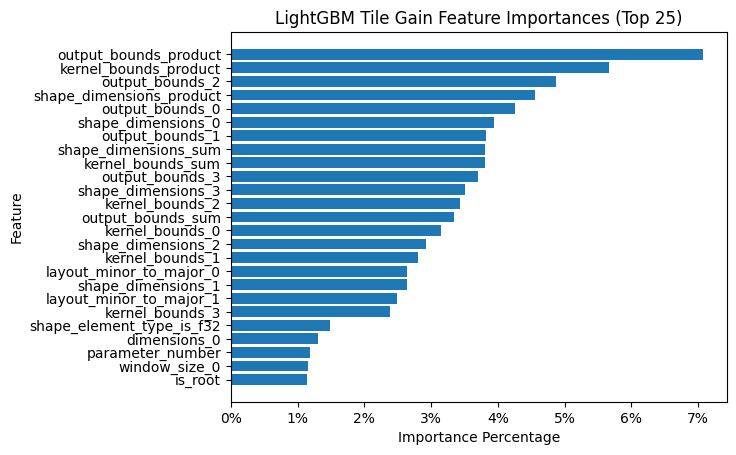

In [34]:
import matplotlib.pyplot as plt
feature_importances = (lgbm.feature_importances_ / sum(model.feature_importances_)) * 100
feature_names = X_train.columns

def map_feature_names(feature_names, config_feature_names, node_feature_names):
    mapped_names = []

    for name in feature_names:
        if name.startswith('config'):
            # Extract the index from the name (assuming the format 'config_feat_X')
            index = int(name.split('_')[-1])
            mapped_names.append(config_feature_names[index])
        elif name.startswith('node'):
            # Extract the index from the name (assuming the format 'node_feat_avg_X')
            index = int(name.split('_')[-1])
            mapped_names.append(node_feature_names[index])
        else:
            # If the feature name doesn't match the expected pattern, keep it as is
            mapped_names.append(name)

    return mapped_names

# Assuming 'feature_names' contains the names of features from your model
feature_names = map_feature_names(feature_names, config_feature_names, node_feature_names)

results = pd.DataFrame({'Features': feature_names,
                        'Importances': feature_importances})
results.sort_values(by='Importances', inplace=True)

ax = plt.barh(results['Features'][-25:], results['Importances'][-25:])
plt.xlabel('Importance Percentage')
plt.ylabel('Feature')
plt.title('LightGBM Tile Gain Feature Importances (Top 25)')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))  # Format x-axis as percentage
plt.savefig('lgbfeat')
plt.show()

In [35]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import random

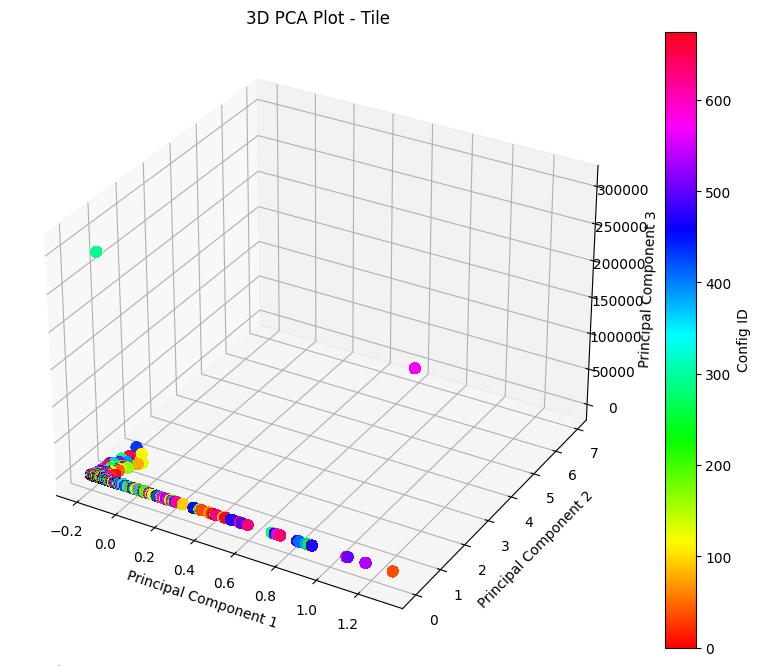

In [36]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(df_valid.drop(columns=['target', 'config_id', 'runtime', 'runtime_norm']))
pca_df = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3'])
pca_df['config_id'] = df_valid['config_id']  # Add the config_id back for coloring

# Plotting the 3D PCA plot with a sample
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(pca_df['PC1'],
                     pca_df['PC2'],
                     pca_df['PC3'],
                     c=pd.factorize(pca_df['config_id'])[0],  # color by config_id
                     cmap='hsv',
                     s = 50)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Plot - Tile')

# Creating a colorbar with config_id labels
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Config ID')
plt.savefig('allpca')
plt.show()

In [39]:
# Assuming df_valid and pca_df are already defined and contain the necessary data
selected_config_ids = [
    'bert_pretraining.4x4.fp16_-18321ad156c55c0b.npz',
    'inception_v3_batch_128_train_-1098e0f697435732.npz',
    'mlperf_bert_batch_24_2x2_-132dd84b121a1252.npz',
    'resnet50.4x4.fp16_-1481da01546b909a.npz',
    'resnet_v1_50_official_batch_128_bf16_-11eca1b246accbac.npz',
    'tf2_bert_pretrain_dynamic_batch_size_-1972c148bcabec74.npz',
    'unet_3d.4x4.bf16_-18d13e5b20bf0cba.npz',
    'unet_3d.4x4.bf16_2c26a09dea860431.npz'
]

df_valid['PC1'], df_valid['PC2'], df_valid['PC3'] = pca_df['PC1'], pca_df['PC2'], pca_df['PC3']

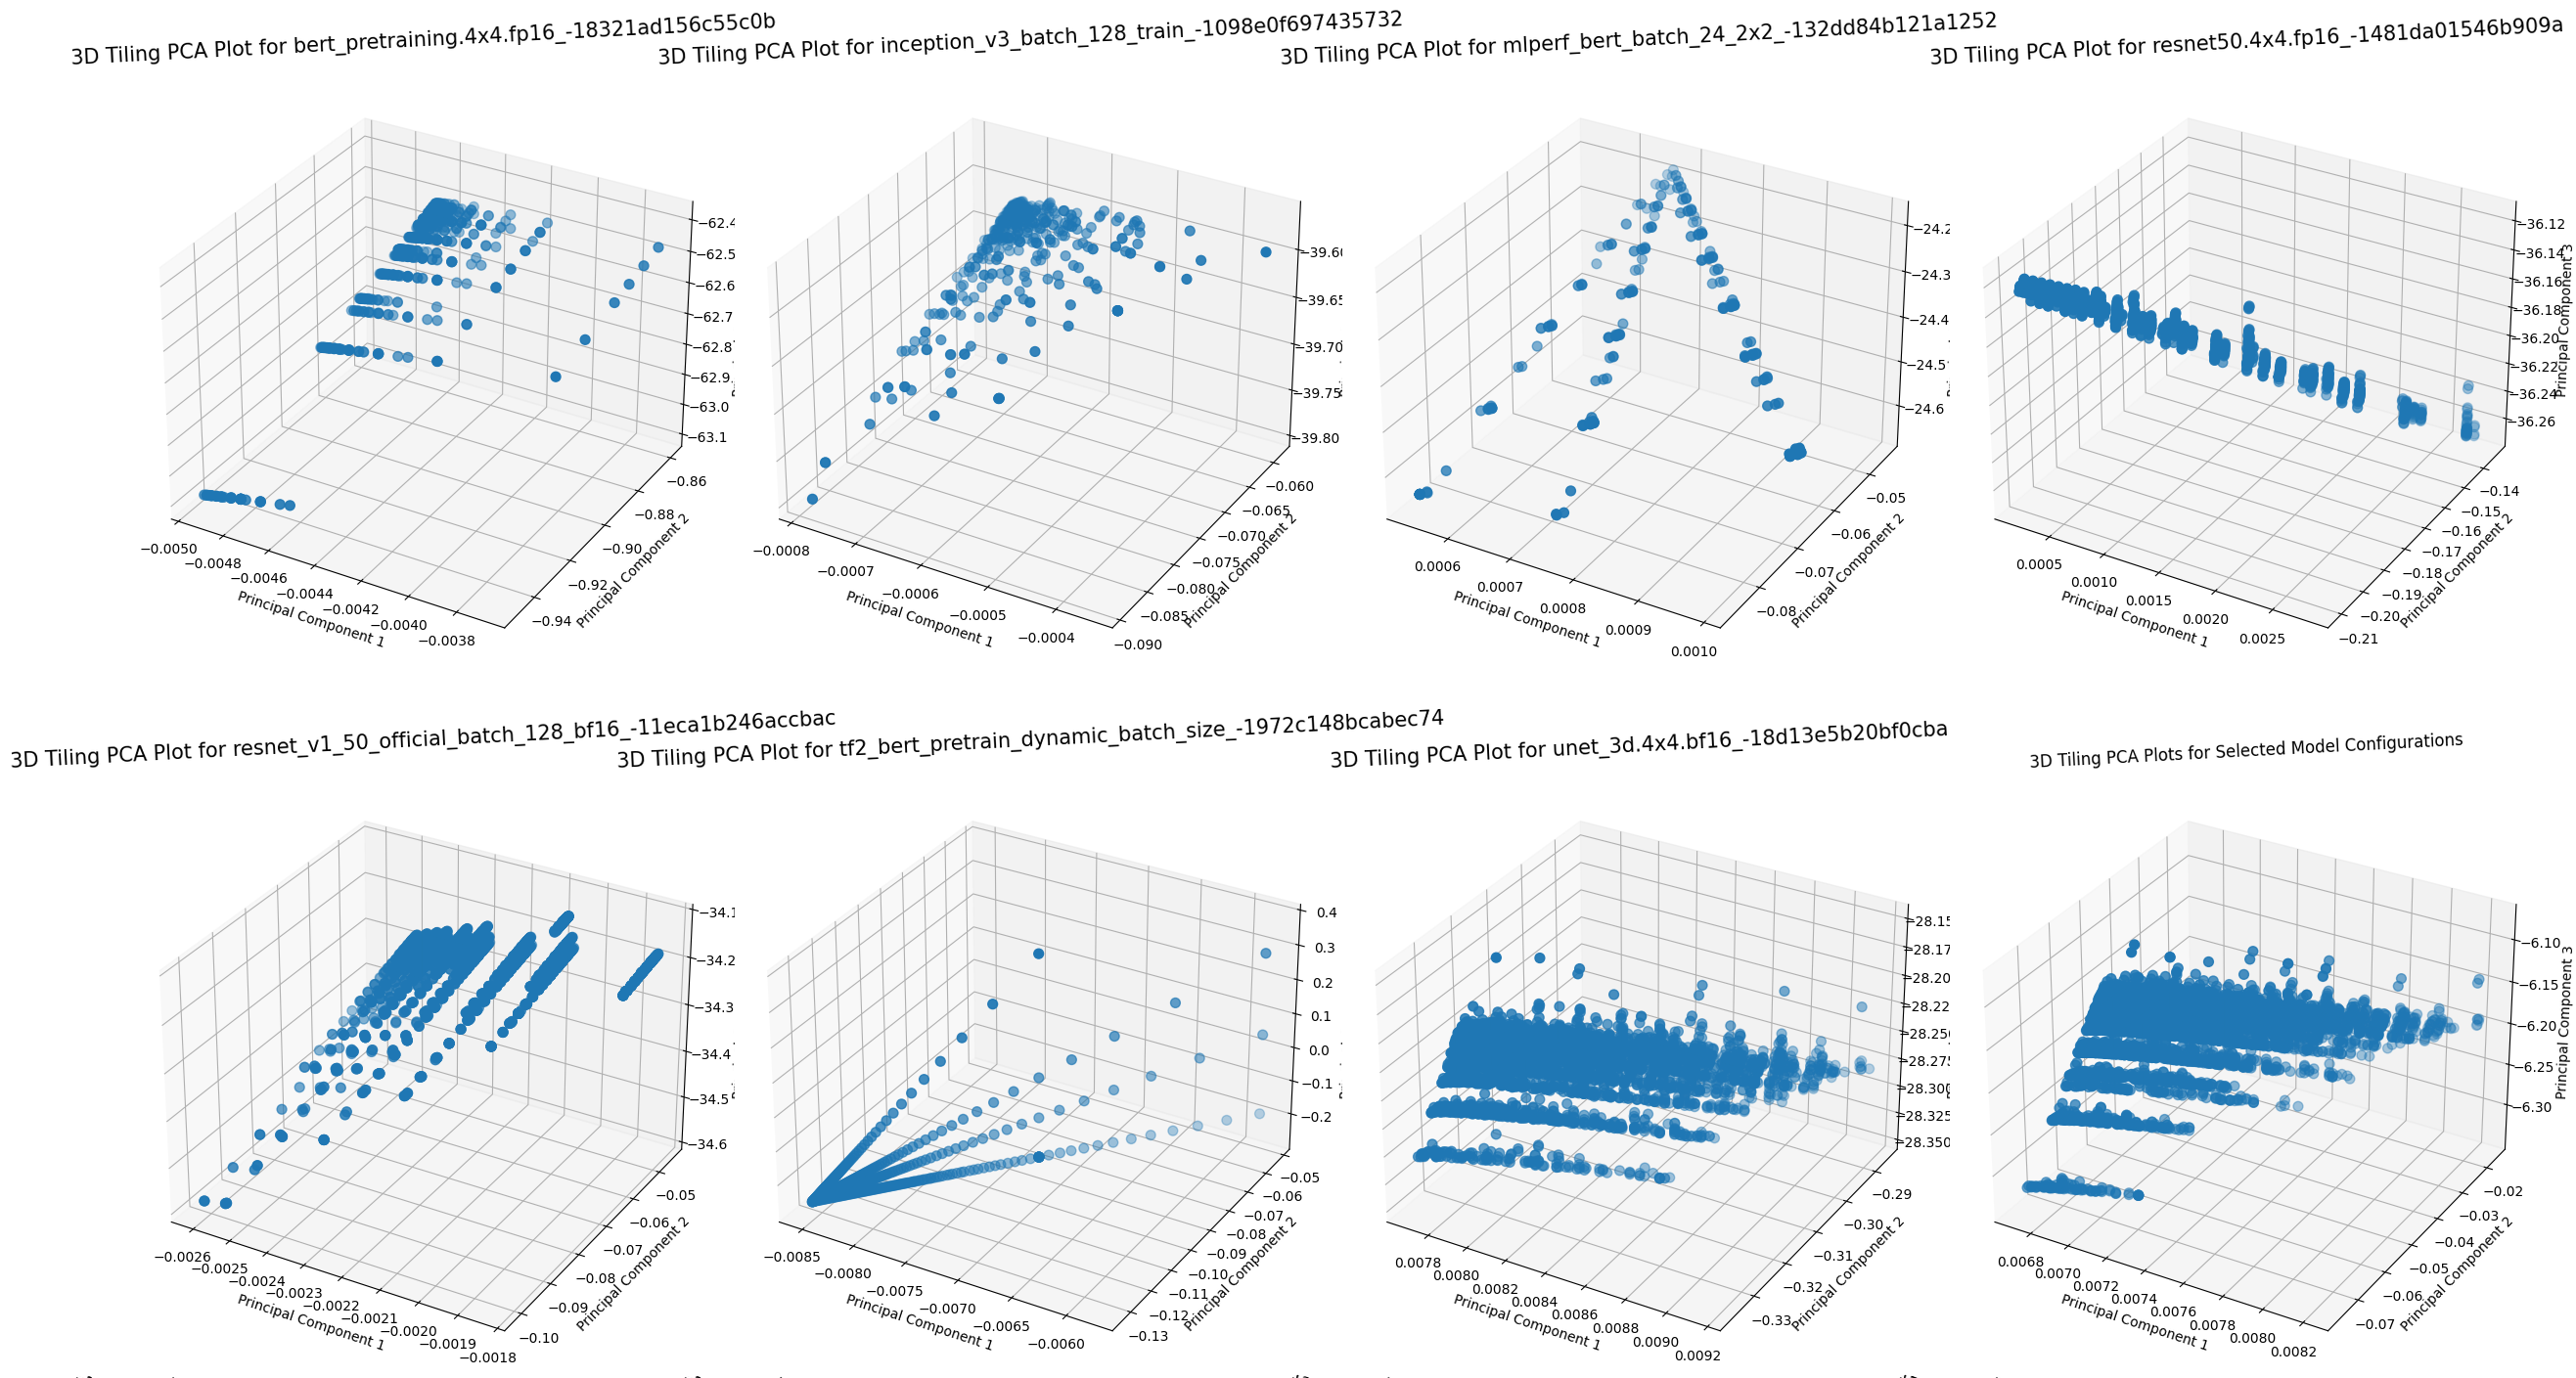

In [40]:
fig = plt.figure(figsize=(25, 15))  # Adjusted figure size for better display

for i, config_id in enumerate(selected_config_ids, 1):
    ax = fig.add_subplot(2, 4, i, projection='3d')  # Adjust for 2x4 layout
    subset = df_valid[df_valid['config_id'] == config_id]

    ax.scatter(subset['PC1'], subset['PC2'], subset['PC3'], s=50)
    title = f'3D Tiling PCA Plot for {config_id.split(".npz")[0]}'
    ax.set_title(title, fontsize=15, rotation=3)  # Rotate title and adjust font size
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')

plt.tight_layout()
plt.savefig('configpca')
plt.title("3D Tiling PCA Plots for Selected Model Configurations")
plt.show()

Code below is old, used for hyperparameter search + LGBM GPU acceleration.

In [ ]:
unique_config_ids = df_valid['config_id'].unique()
train_config_ids, test_config_ids = train_test_split(unique_config_ids, test_size=0.2, random_state=42)

# Creating train and test dataframes based on config_id
train_df = df_valid[df_valid['config_id'].isin(train_config_ids)]
test_df = df_valid[df_valid['config_id'].isin(test_config_ids)]

# Separating features and target variable
X_train = train_df.drop(['target', 'config_id'], axis=1)
y_train = train_df['target']
X_test = test_df.drop(['target', 'config_id'], axis=1)
y_test = test_df['target']

del train_df
del test_df
del train_config_ids
del test_config_ids
del unique_config_ids

# Training models
lin_reg = LinearRegression().fit(X_train, y_train)

alpha_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Setting up GridSearchCV for Lasso Regression
lasso = Lasso()
grid_search_lasso = GridSearchCV(estimator=lasso, param_grid=alpha_grid, cv=3, scoring='neg_mean_squared_error',verbose=4)
grid_search_lasso.fit(X_train, y_train)
lasso_reg = grid_search_lasso.best_estimator_
print("Lasso Alpha")
print(grid_search_lasso.best_params_['alpha'])

ridge = Ridge()
grid_search_ridge = GridSearchCV(estimator=ridge, param_grid=alpha_grid, cv=3, scoring='neg_mean_squared_error',verbose=4)
grid_search_ridge.fit(X_train, y_train)
ridge_reg = grid_search_ridge.best_estimator_
print("Ridge Alpha")
print(grid_search_ridge.best_params_['alpha'])

# Making predictions
train_predictions_lin = lin_reg.predict(X_train)
train_predictions_lasso = lasso_reg.predict(X_train)
train_predictions_ridge = ridge_reg.predict(X_train)

predictions_lin = lin_reg.predict(X_test)
predictions_lasso = lasso_reg.predict(X_test)
predictions_ridge = ridge_reg.predict(X_test)

# Calculating R² scores
r2_lin = r2_score(y_test, predictions_lin)
r2_lasso = r2_score(y_test, predictions_lasso)
r2_ridge = r2_score(y_test, predictions_ridge)

r2_train_lin = r2_score(y_train, train_predictions_lin)
r2_train_lasso = r2_score(y_train, train_predictions_lasso)
r2_train_ridge = r2_score(y_train, train_predictions_ridge)

print("R² Scores Train:")
print(f"Linear Regression: {r2_train_lin}")
print(f"Lasso Regression: {r2_train_lasso}")
print(f"Ridge Regression: {r2_train_ridge}")

print("R² Scores Test:")
print(f"Linear Regression: {r2_lin}")
print(f"Lasso Regression: {r2_lasso}")
print(f"Ridge Regression: {r2_ridge}")

In [ ]:
!rm -r /opt/conda/lib/python3.6/site-packages/lightgbm
!git clone --recursive https://github.com/Microsoft/LightGBM
!apt-get install -y -qq libboost-all-dev

In [ ]:
%%bash
cd LightGBM
rm -r build
mkdir build
cd build
cmake -DUSE_GPU=1 -DOpenCL_LIBRARY=/usr/local/cuda/lib64/libOpenCL.so -DOpenCL_INCLUDE_DIR=/usr/local/cuda/include/ ..
make -j$(nproc)

In [ ]:
#!cd LightGBM/python-package/;python3 setup.py install --precompile

In [ ]:
!mkdir -p /etc/OpenCL/vendors && echo "libnvidia-opencl.so.1" > /etc/OpenCL/vendors/nvidia.icd
!rm -r LightGBM

In [ ]:
!nvidia-smi

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [ ]:
param_dist = {
    'num_leaves': sp_randint(3, 50), 
    'min_child_samples': sp_randint(5, 500), 
    'min_child_weight': sp_uniform(0.01, 0.1),
    'subsample': sp_uniform(0.8, 0.2),
    'colsample_bytree': sp_uniform(0.8, 0.2),
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10],
    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50],
    'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 250, 500, 1000, 1500]
}

In [ ]:
random_search = RandomizedSearchCV(lgbm, param_distributions=param_dist, n_iter=25, cv=4, scoring='neg_mean_squared_error', verbose=4)
random_search.fit(X_train, y_train)

In [ ]:
best_lgbm = random_search.best_estimator_

In [ ]:
random_search.best_params_

In [ ]:
train_preds_lgb = best_lgbm.predict(X_train)

preds_lgb = best_lgbm.predict(X_test)

# Calculating R² scores
r2_lgb = r2_score(y_test, preds_lgb)

r2_train_lgb=r2_score(y_train, train_preds_lgb)

print("R² Scores Train:")
print(f"LGBM: {r2_train_lgb}")

print("R² Scores Test:")
print(f"LGBM: {r2_lgb}")

In [ ]:
extractor = TileDataExtractor('/kaggle/input/predict-ai-model-runtime/npz_all/npz/tile/xla', 'test')
extractor.load_data()
df_test = extractor.get_dataframe()

In [ ]:
# Unpack 'config_feat'
config_feat_df = df_test['config_feat'].apply(pd.Series)
config_feat_df.columns = [f'config_feat_{i}' for i in range(config_feat_df.shape[1])]

# Unpack 'node_feat_avg'
node_feat_avg_df = df_test['node_feat_avg'].apply(pd.Series)
node_feat_avg_df.columns = [f'node_feat_avg_{i}' for i in range(node_feat_avg_df.shape[1])]

# Concatenate with the original DataFrame
df_test = pd.concat([df_test.drop(['config_feat', 'node_feat_avg'], axis=1), config_feat_df, node_feat_avg_df], axis=1)

In [ ]:
df_test = df_test.drop

In [ ]:
lgbm_tile_preds = best_lgbm.predict()